# Load Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torch.distributions import Normal, Independent, Categorical, MultivariateNormal

import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math

from modules import *

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [3]:
class MNISTRotatedDataset(Dataset):
    def __init__(self, mnist_dataset, t=8, angles=[0, 45, 90, 135, 180, 225, 270, 315]):
        self.mnist_dataset = mnist_dataset
        self.t = t
        self.angles = angles

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        rotated_images = []
        for angle in self.angles:
            rotated_image = TF.rotate(image, angle)
            rotated_images.append(rotated_image)
        return torch.stack(rotated_images), label

In [4]:
train_dataset = MNISTRotatedDataset(mnist_train_dataset)
test_dataset = MNISTRotatedDataset(mnist_test_dataset)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

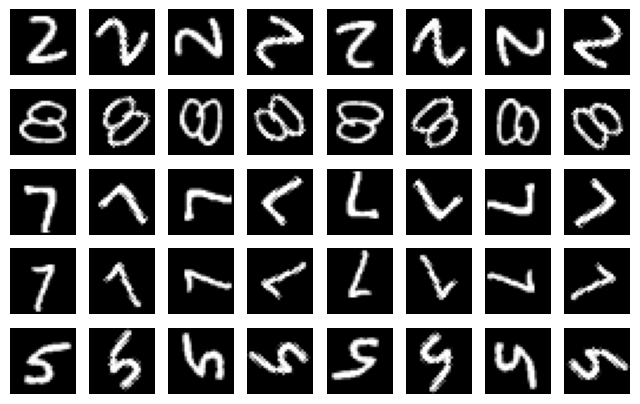

In [5]:
def imshow_grid(images, n_row=8, n_col=8, title="", fig_size_a=10, fig_size_b=10):
    fig, axes = plt.subplots(n_row, n_col, figsize=(fig_size_a, fig_size_b))
    fig.suptitle(title)
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow(images[i,j].squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.show()

# Visualize a batch of training data
batch_images, batch_labels = next(iter(train_dataloader))
imshow_grid(batch_images[0:5],n_row=5, fig_size_a=8, fig_size_b=5)  # Displaying the first batch

In [6]:
torch.min(batch_images), torch.max(batch_images)

(tensor(0.), tensor(1.))

In [7]:
batch_images.shape

torch.Size([64, 8, 1, 28, 28])

# Create the VRNN

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
!nvidia-smi

Sun Sep  1 15:23:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  Tesla T4                       Off | 00000000:1C:00.0 Off |                    0 |
| N/A   72C    P0              44W /  70W |   2636MiB / 15360MiB |     44%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|    0   N/A  N/A   2239500      C   /vol/bitbucket/am9923/myenv/bin/python      102MiB |
|    0   N

In [8]:
class VRNN(nn.Module):
    def __init__(self, h_dim, z_dim, beta=1, constant_logvar=True):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.beta = beta
        self.constant_logvar = constant_logvar
        
        # Feature extractors
        self.phi_x = nn.Sequential(
                        nn.Conv2d(1, 32, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),

                        nn.Conv2d(32, 64, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(),

                        nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(),

                        nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),

                        nn.Conv2d(256, 512, kernel_size= 3, stride= 2, padding  = 1),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(),            
                        nn.Flatten(),
                
                        nn.Linear(512, h_dim)
        )
        
        self.phi_z = nn.Sequential(
                        nn.Linear(z_dim, h_dim),
                        nn.ReLU())        
        
        # Prior distribution
        self.prior = nn.Sequential(
                        nn.Linear(h_dim, h_dim),
                        nn.ReLU())

        self.prior_mean = nn.Linear(h_dim, z_dim)
        self.prior_logvar = nn.Linear(h_dim, z_dim)
        
        
        # Encoder
        self.encoder = nn.Sequential(
                        nn.Linear(h_dim + h_dim, h_dim),
                        nn.ReLU(),
                        nn.Linear(h_dim, h_dim),
                        nn.ReLU())
        
        self.mu_layer = nn.Linear(h_dim, z_dim)
        self.logvar_layer = nn.Linear(h_dim, z_dim)
        
        # Decoder
        self.decoder_linear = nn.Linear(2 * h_dim, 512)
        self.decoder = nn.Sequential(
                         nn.ConvTranspose2d(8,64,kernel_size=3,stride=1,padding=1), # [16,8,8] --> [16,8,8]
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
        
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
            
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=2,padding=1), # [16,8,8] --> [8,15,15]
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
            
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1), 
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),
        
                         nn.ConvTranspose2d(64,64,kernel_size=3,stride=1,padding=1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),

                         nn.ConvTranspose2d(64,64,kernel_size=2,stride=2,padding=1), # [8,15,15] --> [4,28,28]
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(),                         
                                                                                                                                                                                                                                            
            
                         #nn.Conv2d(32,1,kernel_size= 3, padding= 1),
                         #nn.Sigmoid()           
        )
        self.decoder_mean = nn.Sequential(
                         nn.Conv2d(64,1,kernel_size= 3, padding= 1),
                         nn.Sigmoid()                        
        )
        self.decoder_logvar = torch.tensor(5e-4,device=device)
        
        
        # Recurrence
        self.rnn = nn.GRU(h_dim + h_dim, h_dim)
        
    def reparametrize(self, mu, logvar):
        epsilon = torch.randn_like(logvar)
        z_reparametrized = mu + torch.exp(logvar/2) * epsilon
        return z_reparametrized
    
    def forward(self, x):
        (B,T,*_) = x.shape
        loss = torch.ones((T,B))
        recons = torch.zeros(B, T, 28, 28)
        
        h = torch.zeros((1, B, self.h_dim), device=device)
        for t in range(T):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_logvar(prior_t)            
            
            # Extract features
            phi_x_t = self.phi_x(x[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)
            
            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Decode (we use the mean, could create a Normal distribution here and sample from it)
            recon_x = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            
            recon_x = recon_x.view(-1, 8, 8, 8)
            recon_x = self.decoder(recon_x)
            recon_x = self.decoder_mean(recon_x)
            recons[:,t] = recon_x.squeeze()
            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)            
            
            # Update losses     
            loss[t] = loss_function(recon_x, x[:,t], enc_mean_t, enc_std_t, prior_mean_t, prior_std_t, self.beta)

        total_loss = (loss).sum(axis=0).mean()   
            
        return total_loss, recons
    
    def sample(self, seq_len = 8, n_samples = 10):
        samples = torch.zeros((n_samples, seq_len, 28, 28))
        self.eval()
        for i in range(n_samples):
            with torch.inference_mode():
                sample = torch.zeros(8, 28,28, device=device)
                h = torch.zeros(1, 1, self.h_dim, device=device)
                for t in range(seq_len):
                    # Prior
                    prior_t = self.prior(h[0])
                    prior_mean_t = self.prior_mean(prior_t)
                    prior_logvar_t = self.prior_logvar(prior_t)
                    # Sample
                    z_t = self.reparametrize(prior_mean_t, prior_logvar_t)
                    
                    # Extract Features
                    phi_z_t = self.phi_z(z_t)

                    # Decode
                    sample_t = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
                    sample_t = sample_t.view(-1, 8, 8, 8)
                    sample_t = self.decoder(sample_t)
                    sample_t = self.decoder_mean(sample_t)

                    phi_x_t = self.phi_x(sample_t)

                    #recurrence
                    _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

                    sample[t] = sample_t.data
            samples[i] = sample.cpu()
        return samples

    def predict_sequence(self, x, seq_len=None):
        # Input [B,3,3,28,28]
        (B, T, C, H, W) = x.size()

        h = torch.zeros((1, B, self.h_dim), device=device)
        for t in range(T):          
            # Extract features
            phi_x_t = self.phi_x(x[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)
            
            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

        samples = torch.zeros((B, seq_len, C, H, W))

        for t in range(seq_len):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_logvar_t = self.prior_logvar(prior_t)
            # Sample
            z_t = self.reparametrize(prior_mean_t, prior_logvar_t)
            
            # Extract Features
            phi_z_t = self.phi_z(z_t)

            # Decode
            sample_t = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            sample_t = sample_t.view(-1, 8, 8, 8)
            sample_t = self.decoder(sample_t)
            sample_t = self.decoder_mean(sample_t)

            phi_x_t = self.phi_x(sample_t)

            samples[:,t] = sample_t

            #recurrence
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

        return samples

    def iwae(self,x,N):
        B = x.shape[0]
        T = x.shape[1]
        C = x.shape[2]
        H = x.shape[3]
        W = x.shape[4]
        # Similar to https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/vrnn.py
        inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
        # Reshape so it passes through conv2d layers
        inputs = inputs.reshape((B*N,T,C,H,W))
        loss = torch.ones((T,N,B))
        h = torch.zeros((1, B*N, self.h_dim), device=device, dtype=x.dtype)
        for t in range(T):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_logvar(prior_t)            
            
            # Extract features
            phi_x_t = self.phi_x(inputs[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)

            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Decode (we use the mean, could create a Normal distribution here and sample from it)
            recon_x = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            recon_x = recon_x.view(-1, 8, 8, 8)
            recon_x = self.decoder(recon_x)
            dec_mean_t = self.decoder_mean(recon_x)

            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            # Calculate loss
            loss_t = loss_function(dec_mean_t, inputs[:,t], enc_mean_t, enc_std_t, prior_mean_t, prior_std_t, self.beta)

            # Change logprobs to appropriate dimensions and save them
            loss_t = loss_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]

            loss[t] = loss_t

        logW = logsumexp((-loss).sum(axis=0), axis=0).mean() - math.log(N)
        return logW, loss

    def fivo(self,x,N):
        B = x.shape[0]
        T = x.shape[1]
        C = x.shape[2]
        H = x.shape[3]
        W = x.shape[4]
        # Similar to https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/vrnn.py
        inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
        # Reshape so it passes through conv2d layers
        inputs = inputs.reshape((B*N,T,C,H,W))
        loss = torch.ones((T,N,B))
        h = torch.zeros((1, B*N, self.h_dim), device=device, dtype=x.dtype)
        for t in range(T):
            # Prior
            prior_t = self.prior(h[0])
            prior_mean_t = self.prior_mean(prior_t)
            prior_std_t = self.prior_logvar(prior_t)            
            
            # Extract features
            phi_x_t = self.phi_x(inputs[:,t])
            
            # Encode
            enc_t = self.encoder(torch.cat([phi_x_t, h[0]], 1))
            enc_mean_t = self.mu_layer(enc_t)
            enc_std_t = self.logvar_layer(enc_t)
            
            # Sample
            z_t = self.reparametrize(enc_mean_t, enc_std_t)

            # Extract features
            phi_z_t = self.phi_z(z_t)
            
            # Decode (we use the mean, could create a Normal distribution here and sample from it)
            recon_x = self.decoder_linear(torch.cat([phi_z_t, h[0]], 1))
            recon_x = recon_x.view(-1, 8, 8, 8)
            recon_x = self.decoder(recon_x)
            dec_mean_t = self.decoder_mean(recon_x)

            # Calculate loss
            loss_t = loss_function(dec_mean_t, inputs[:,t], enc_mean_t, enc_std_t, prior_mean_t, prior_std_t, self.beta)

            # Change logprobs to appropriate dimensions and save them
            loss_t = loss_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]

            # Resampling step
            log_W_t = - loss_t - math.log(N)

            z_t = z_t.reshape((N,B,-1))
            phi_z_t = phi_z_t.reshape((N,B,-1))
            dec_mean_t = dec_mean_t.reshape((N,B,-1))

            z_t = resample(z_t,log_W_t,N)
            phi_z_t = resample(phi_z_t,log_W_t,N)
            dec_mean_t = resample(dec_mean_t,log_W_t,N)

            z_t = z_t.reshape((N*B,-1))
            phi_z_t = phi_z_t.reshape((N*B,-1))
            dec_mean_t = dec_mean_t.reshape((N*B,-1))            

            # Update h
            _, h = self.rnn(torch.cat([phi_x_t, phi_z_t], 1).unsqueeze(0), h)

            loss[t] = loss_t
        logW = logsumexp(-loss-math.log(N), axis=1).sum(axis=0).mean()
        return logW, (loss)                


In [9]:
def loss_function(recon_x, x, mean_1, logvar_1, mean_2, logvar_2, beta, eps=1e-3):
       
    reconstruction_loss = ((recon_x - x)**2).sum(dim=(1,2,3))
    kld_element =  ((logvar_2 - logvar_1) + 
        (torch.exp(logvar_1/2).pow(2) + (mean_1 - mean_2).pow(2)) /
        torch.exp(logvar_2/2).pow(2) - 1)
    kld_loss = 0.5 * torch.sum(kld_element,dim=1)
    loss = reconstruction_loss + beta * kld_loss
    return loss

def normal_logprob(x,mu,sigma):
    """
    Function that calculates the log probability of a multivariate normal distribution
    with diagonal covariance matrix.
    
    Args:
        x (torch.Tensor): Value at which the log probability is evaluated. Shape: [B,d]
        mu (torch.Tensor): Mean of the multivariate distribution. Shape: [B,d]
        sigma (torch.Tensor): Diagonal values of the covariance matrix of the
                              multivariate distribution. Shape: [B,d]
    """
    dev = x.device
    B,d = mu.shape
    
    if len(sigma.shape) == 0:
        sigma = sigma.repeat(B,d)

    a = torch.tensor(([-(d/2) * torch.log(torch.tensor(2)*torch.pi)]*B), device=dev)
    b = - 0.5 * torch.log(sigma).sum(1)
    c = - 0.5 * (((x - mu)**2/sigma).sum(1))
    return a+b+c

def ess_criterion(log_weights, threshold=0.5):
    """
    Modified from https://github.com/AdrienCorenflos/differentiableFIVO/blob/master/fivo/smc.py
    Function that calculates whether we should resample or not based on the weights of the particles.
    It works both with normalised and unnormalised weights.
    Note that the numerator is just log(1) = 0 if the weights are normalised.

    Args:
        log_weights (torch.Tensor): Logarithms of the weights of the particles. Shape [N,B]
        threshold (float, optional): Threshold value to decide if we should resample.
                                     Default is 0.5.
    Returns:
        bool: True if we should resample. Shape [B]
    """
    threshold = torch.tensor(threshold)
    # log_weights = torch.tensor([np.log(0.5),np.log(0.5)])

    num_particles = torch.tensor(log_weights.shape[0])
    numerator = 2 * logsumexp(log_weights, axis=0)
    denomenator = logsumexp(2 * log_weights, axis=0)
    log_ess = numerator - denomenator
    return log_ess <= torch.log(num_particles * threshold)

def resample(x,weights,N):
    """
    Modified from https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/system/fivo.py
    Function that resamples N particles based on their weight
    Args: 
        x (torch.Tensor): Shape is [P,B,H]
        weights (torch.Tensor): Log weights. Shape is [P,B]
        N (int): Number of particles to resample
    Returns:
        torch.Tensor: Resampled particles of shape [P,B,H] 
    """
    weights = weights - logsumexp(weights, axis=0) # Normalise log weights
    categorical = Categorical(logits=weights.permute([1,0]))    
    indices = categorical.sample(torch.Size([N])) # shape [P,B]
    x = torch.gather(x, 0, indices.unsqueeze(2).repeat(1,1,x.size(2)))
    return x

# ELBO

In [12]:
epochs = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/938 [00:00<?, ?batch/s]/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0: 100%|██████████| 938/938 [02:45<00:00,  5.66batch/s, loss=88.186] 
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Recon MSE: 0.01785
Pred MSE: 0.02450


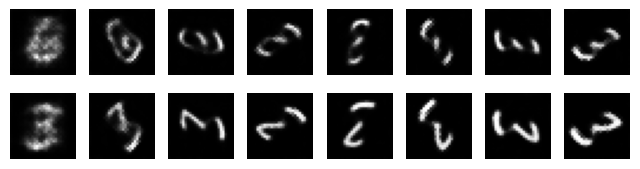

Epoch 1: 100%|██████████| 938/938 [02:42<00:00,  5.77batch/s, loss=74.037]


Recon MSE: 0.01434
Pred MSE: 0.02074


Epoch 2: 100%|██████████| 938/938 [02:43<00:00,  5.75batch/s, loss=63.687]


Recon MSE: 0.01215
Pred MSE: 0.01672


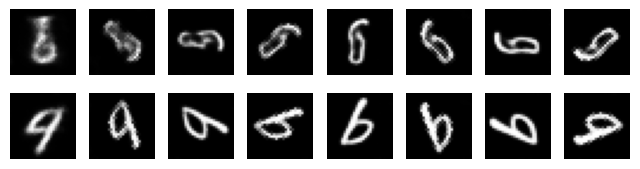

Epoch 3: 100%|██████████| 938/938 [02:42<00:00,  5.76batch/s, loss=63.351]


Recon MSE: 0.01155
Pred MSE: 0.01345


Epoch 4: 100%|██████████| 938/938 [02:41<00:00,  5.80batch/s, loss=61.727]


Recon MSE: 0.01081
Pred MSE: 0.01392


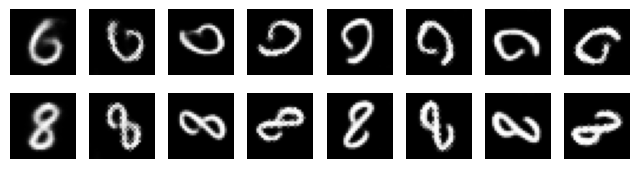

Epoch 5: 100%|██████████| 938/938 [02:42<00:00,  5.77batch/s, loss=55.752]


Recon MSE: 0.01071
Pred MSE: 0.01252


Epoch 6: 100%|██████████| 938/938 [02:41<00:00,  5.81batch/s, loss=50.182]


Recon MSE: 0.01064
Pred MSE: 0.01210


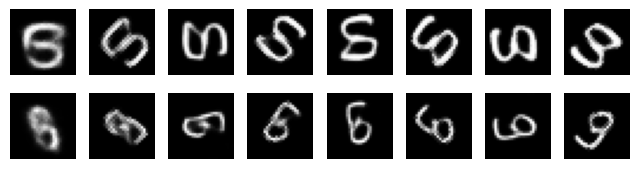

Epoch 7: 100%|██████████| 938/938 [02:43<00:00,  5.74batch/s, loss=53.115]


Recon MSE: 0.01087
Pred MSE: 0.01108


Epoch 8: 100%|██████████| 938/938 [02:52<00:00,  5.44batch/s, loss=50.884]


Recon MSE: 0.01116
Pred MSE: 0.01011


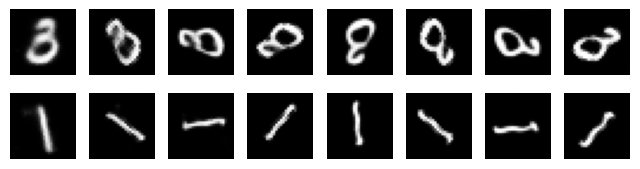

Epoch 9: 100%|██████████| 938/938 [02:53<00:00,  5.39batch/s, loss=46.431]


Recon MSE: 0.01045
Pred MSE: 0.00910


In [13]:
total_losses = []

test_mse_losses = [] 
predict_mse_losses = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            data = data.to(device)
            optimizer.zero_grad()
            total_loss, _ = model(data)

            # Keep in memory the losses
            total_losses.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.3f}")
    model.eval()
    with torch.inference_mode():
        mse_values = []
        predict_mse = []
        for (sample, _) in test_dataloader:
            B, T, C, H, W = sample.size()                    
            obs_var = sample.float().to(device)
            _, x_hat = model(obs_var)
            preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
            obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
            preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
            mse = np.mean(((x_hat - obs_var) ** 2))
            pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))  
            mse_values.append(mse)
            predict_mse.append(pred_mse)            
        mse_val = sum(mse_values) / len(mse_values)
        pred_val = sum(predict_mse) / len(predict_mse)
        test_mse_losses.append(mse_val.item())
        predict_mse_losses.append(pred_val.item())   
        print(f"Recon MSE: {mse_val:.5f}")
        print(f"Pred MSE: {pred_val:.5f}")                       

    if epoch%2==0:       
        with torch.inference_mode():
            s = model.sample(seq_len = 8, n_samples=2)
            s = s.cpu().numpy()     
        imshow_grid(s, n_row=2, n_col=8, fig_size_a=8, fig_size_b=2)                  

In [13]:
PATH = 'vrnn_mnist_elbo_2.pth'
# torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
test_mse_losses, predict_mse_losses

([0.017851601177944414,
  0.014344930625225924,
  0.012148763524674916,
  0.011549012935897218,
  0.010809059844269782,
  0.010707407470651065,
  0.010637391665125196,
  0.010870372133824644,
  0.011162561152271832,
  0.010449657016256941],
 [0.024504202264773695,
  0.020736488666904123,
  0.016723872150612783,
  0.013453072832920883,
  0.01391565015751727,
  0.01252430619648363,
  0.012098594132480742,
  0.01107835779084435,
  0.010105040926439098,
  0.009100239942015349])

Text(0, 0.5, 'Training Loss')

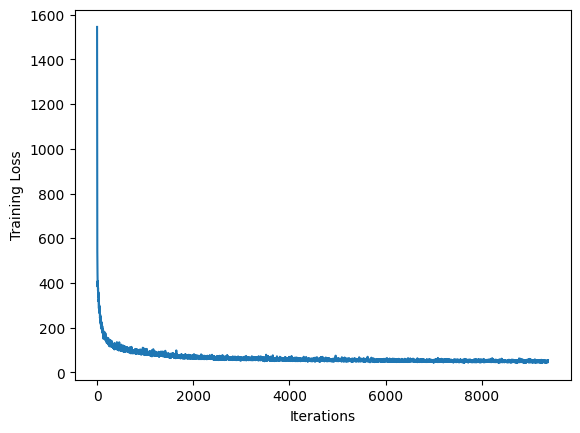

In [16]:
plt.plot(total_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

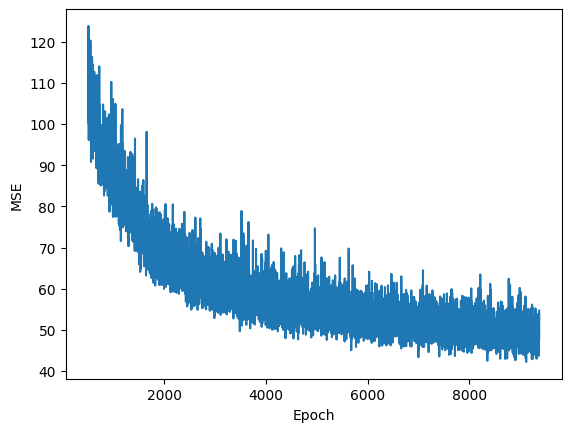

In [17]:
plt.plot(np.arange(500,len(total_losses)),total_losses[500:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

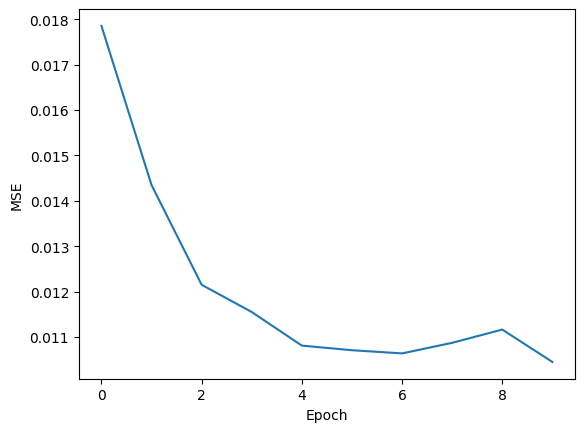

In [18]:
plt.plot(test_mse_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

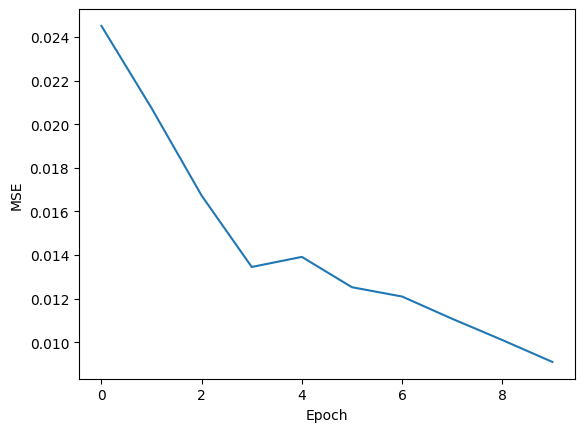

In [19]:
plt.plot(predict_mse_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [20]:
# Training time: 30.5min
print(f"Last ELBO Loss: {total_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_losses[-1]:.6f}")
print(f"Last Pred MSE: {predict_mse_losses[-1]:.6f}")

Last ELBO Loss: 54.7
Last Test MSE: 0.010450
Last Pred MSE: 0.009100


In [21]:
print(f"Best ELBO Loss: {min(total_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_losses):.6f}")
print(f"Best Pred MSE: {min(predict_mse_losses):.6f}")

Best ELBO Loss: 42.2
Best Test MSE: 0.010450
Best Pred MSE: 0.009100


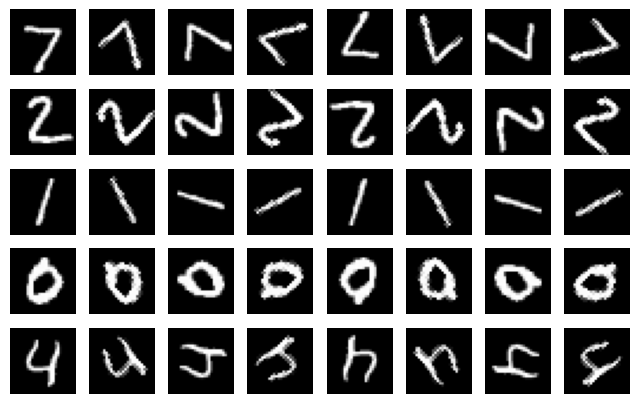

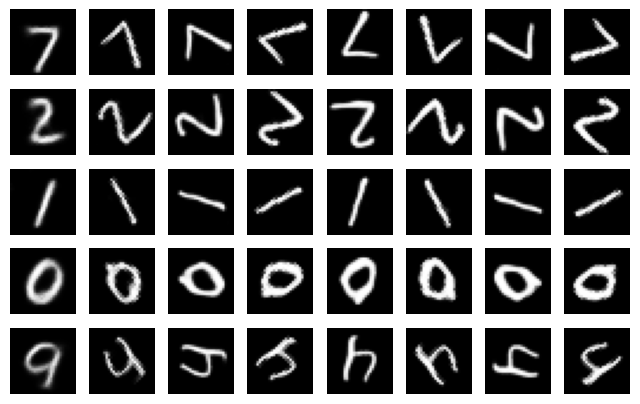

In [23]:
# Reconstructions

n_samples = 5
t = 8
recons = torch.zeros(n_samples, t, 28, 28)
model.eval()

with torch.inference_mode():
    x,_ = next(iter(test_dataloader))
    x = x.to(device)
    _,recon_x = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.unsqueeze(2).cpu().numpy()

imshow_grid(x, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid(recon_x, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [24]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.033805
t=1 MSE per pixel:0.014430
t=2 MSE per pixel:0.008060
t=3 MSE per pixel:0.005697
t=4 MSE per pixel:0.004820
t=5 MSE per pixel:0.004616
t=6 MSE per pixel:0.004145
t=7 MSE per pixel:0.004555


In [25]:
mse_T

array([0.03380467, 0.01442992, 0.00805971, 0.00569732, 0.00482013,
       0.00461603, 0.00414528, 0.0045546 ], dtype=float32)

Text(0, 0.5, 'MSE per Pixel')

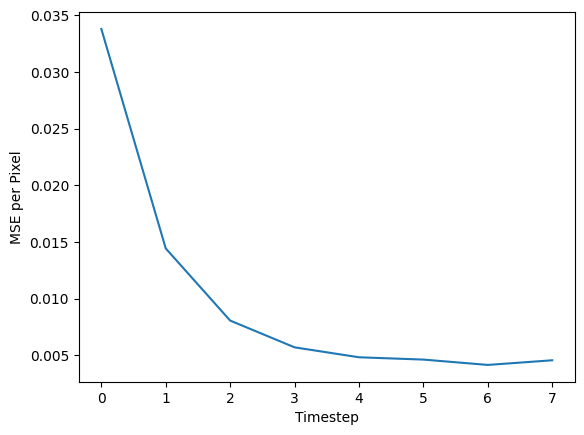

In [26]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.ylabel('MSE per Pixel')

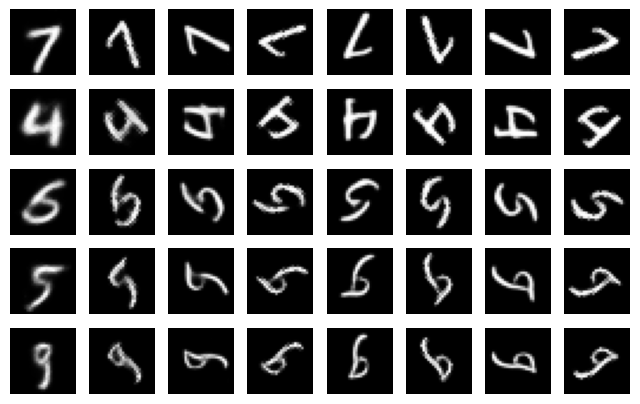

In [29]:
# Create samples

n_samples = 5
t = 8
model.eval()
with torch.inference_mode():
    s = model.sample(seq_len = t, n_samples=n_samples)
    s = s.cpu().numpy()
 
imshow_grid(s, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)      

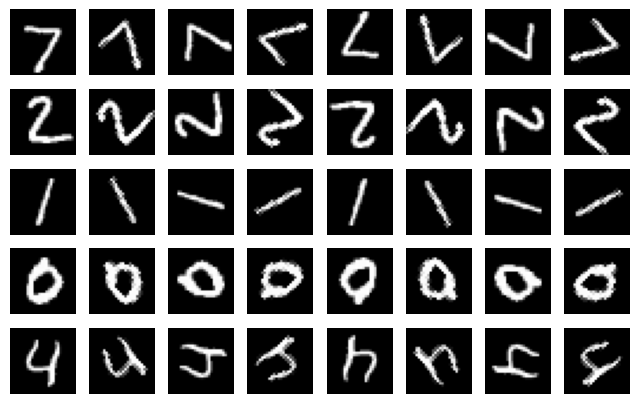

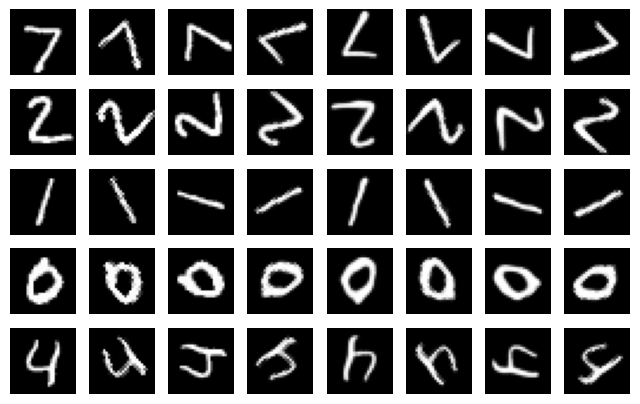

In [30]:
# Predictions

with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device))
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=5).cpu()
    x = x.cpu()
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.numpy()

imshow_grid((x[:5]), n_row=5, n_col=8, fig_size_a=8, fig_size_b=5)
imshow_grid((preds[:5]), n_row=5, n_col=8, fig_size_a=8, fig_size_b=5)


In [31]:
with torch.inference_mode():
    predict_mse = []
    for (sample,_) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        preds = model.predict_sequence(obs_var[:,:3], seq_len=5)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 5, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [32]:
predict_mse[0]

[0.005610985215753317,
 0.006247667130082846,
 0.008468869142234325,
 0.009592835791409016,
 0.012098925188183784]

([<matplotlib.axis.XTick at 0x7b0c2f373bb0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

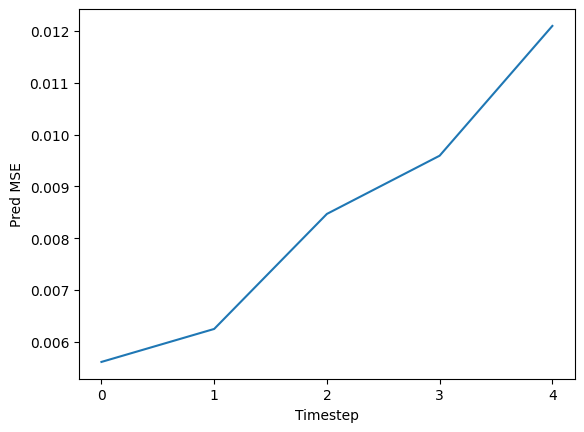

In [33]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')
plt.xticks(np.arange(0,5))

In [14]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO>IWAE>ELBO

with torch.inference_mode():
    elbo_list = []
    iwae_list = []
    fivo_list = []
    for (sample,_) in tqdm.tqdm(test_dataloader):
        obs_var = sample.float().to(device)
        elbo, _ = model(obs_var)
        iwae, _ = model.iwae(obs_var, 10)
        fivo, _ = model.fivo(obs_var, 10)
        elbo = -elbo
        elbo_list.append(elbo)
        iwae_list.append(iwae)
        fivo_list.append(fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.2f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.2f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

  0%|          | 0/79 [00:00<?, ?it/s]/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 79/79 [00:53<00:00,  1.47it/s]

ELBO: -59.12
IWAE: -55.99
FIVO: -56.65


# IWAE

In [12]:
epochs = 10
particles = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/938 [00:00<?, ?batch/s]/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0: 100%|██████████| 938/938 [05:02<00:00,  3.10batch/s, loss=88.7583] 


Recon MSE: 0.01765
Pred MSE: 0.02282


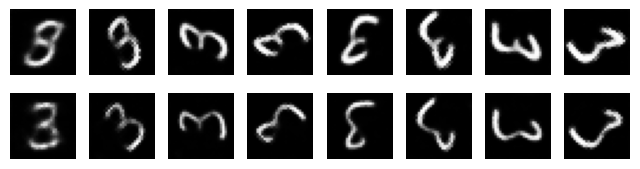

Epoch 1: 100%|██████████| 938/938 [05:01<00:00,  3.11batch/s, loss=61.5975]


Recon MSE: 0.01642
Pred MSE: 0.02414


Epoch 2: 100%|██████████| 938/938 [05:02<00:00,  3.10batch/s, loss=59.8976]


Recon MSE: 0.01538
Pred MSE: 0.01928


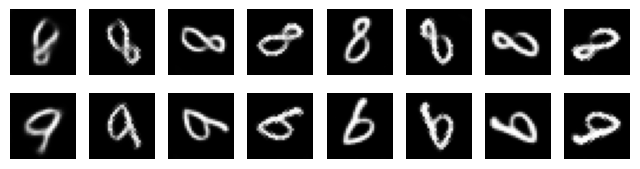

Epoch 3: 100%|██████████| 938/938 [05:09<00:00,  3.03batch/s, loss=60.7528]


Recon MSE: 0.01409
Pred MSE: 0.01710


Epoch 4: 100%|██████████| 938/938 [05:09<00:00,  3.03batch/s, loss=58.9701]


Recon MSE: 0.01367
Pred MSE: 0.01332


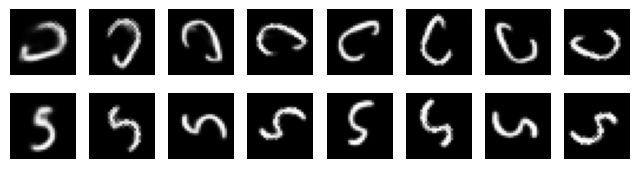

Epoch 5: 100%|██████████| 938/938 [05:03<00:00,  3.09batch/s, loss=48.0836]


Recon MSE: 0.01220
Pred MSE: 0.01160


Epoch 6: 100%|██████████| 938/938 [05:01<00:00,  3.11batch/s, loss=44.6911]


Recon MSE: 0.01255
Pred MSE: 0.01224


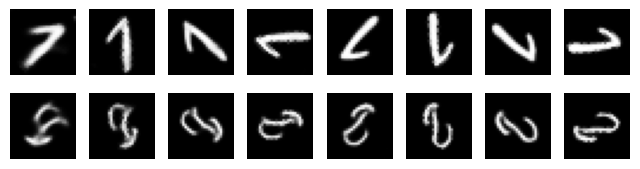

Epoch 7: 100%|██████████| 938/938 [05:01<00:00,  3.11batch/s, loss=44.9788]


Recon MSE: 0.01492
Pred MSE: 0.01710


Epoch 8: 100%|██████████| 938/938 [05:01<00:00,  3.11batch/s, loss=44.2003]


Recon MSE: 0.01264
Pred MSE: 0.01169


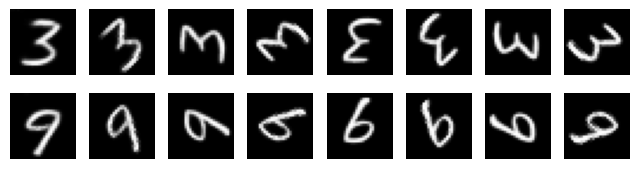

Epoch 9: 100%|██████████| 938/938 [05:08<00:00,  3.04batch/s, loss=41.6481]


Recon MSE: 0.01319
Pred MSE: 0.01144


In [37]:
total_losses_iwae = []
mse_losses_iwae = []
predict_mse_iwae = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            data = data.to(device)
            optimizer.zero_grad()
            total_loss, log_probs = model.iwae(data, particles)
            total_loss = - total_loss

            # Keep in memory the losses
            total_losses_iwae.append(total_loss.item())

            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            total_loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.4f}")
    model.eval()
    with torch.inference_mode():
        mse_values = []
        predict_mse = []
        for (sample, _) in test_dataloader:
            B, T, C, H, W = sample.size()                    
            obs_var = sample.float().to(device)
            _, x_hat = model(obs_var)
            preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
            obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
            preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
            mse = np.mean(((x_hat - obs_var) ** 2))
            pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))  
            mse_values.append(mse)
            predict_mse.append(pred_mse)            
        mse_val = sum(mse_values) / len(mse_values)
        pred_val = sum(predict_mse) / len(predict_mse)
        mse_losses_iwae.append(mse_val.item())
        predict_mse_iwae.append(pred_val.item())   
        print(f"Recon MSE: {mse_val:.5f}")
        print(f"Pred MSE: {pred_val:.5f}")                       

    if epoch%2==0:       
        with torch.inference_mode():
            s = model.sample(seq_len = 8, n_samples=2)
            s = s.cpu().numpy()     
        imshow_grid(s, n_row=2, n_col=8, fig_size_a=8, fig_size_b=2)

In [13]:
PATH = 'vrnn_mnist_iwae_2.pth'
#torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [39]:
mse_losses_iwae, predict_mse_iwae

([0.017650789828805982,
  0.016422372205253645,
  0.01537725589933652,
  0.014090868161071706,
  0.01366912445077036,
  0.012196217675375032,
  0.012553594664588004,
  0.014917589841952806,
  0.012643958406546448,
  0.013186731929831866],
 [0.022824842718583118,
  0.024136154146134098,
  0.019280909713876398,
  0.01710004642417159,
  0.013316926263461384,
  0.011595009755390354,
  0.01224486104248068,
  0.017103864952827556,
  0.01168707667413769,
  0.011435443547236013])

Text(0, 0.5, 'Training Loss')

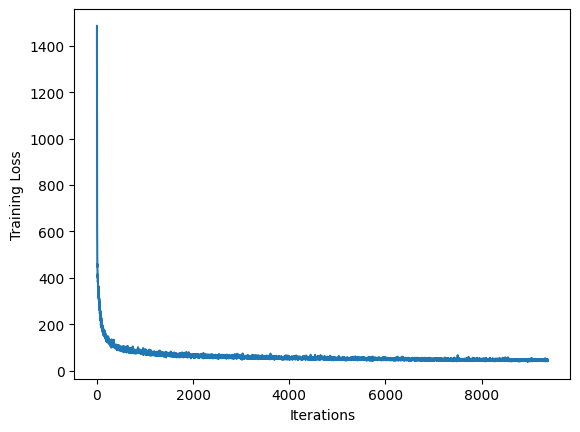

In [40]:
plt.plot(total_losses_iwae)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

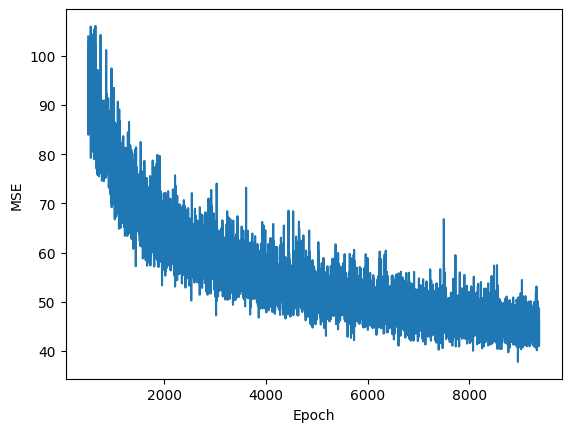

In [41]:
plt.plot(np.arange(500,len(total_losses_iwae)),total_losses_iwae[500:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

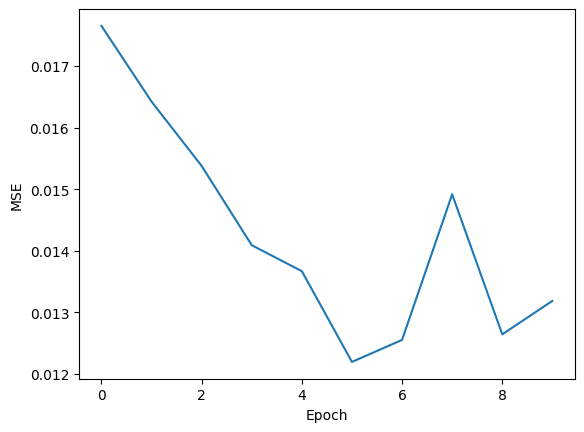

In [42]:
plt.plot(mse_losses_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

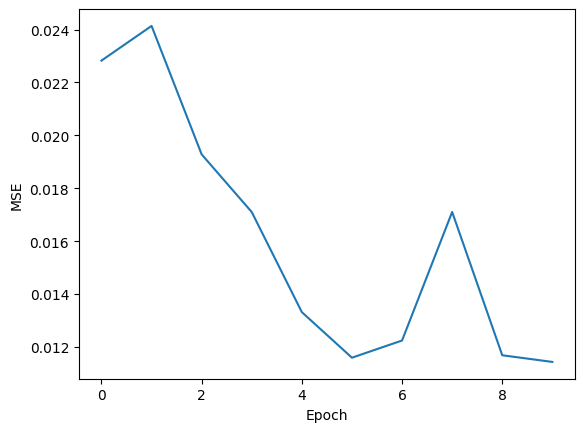

In [43]:
plt.plot(predict_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [44]:
# Training time: 54min
print(f"Last IWAE Loss: {total_losses_iwae[-1]:.1f}")
print(f"Last Test MSE: {mse_losses_iwae[-1]:.6f}")
print(f"Last Pred MSE: {predict_mse_iwae[-1]:.6f}")

Last IWAE Loss: 45.9
Last Test MSE: 0.013187
Last Pred MSE: 0.011435


In [45]:
print(f"Best IWAE Loss: {min(total_losses_iwae):.1f}")
print(f"Best Test MSE: {min(mse_losses_iwae):.6f}")
print(f"Best Pred MSE: {min(predict_mse_iwae):.6f}")

Best IWAE Loss: 37.8
Best Test MSE: 0.012196
Best Pred MSE: 0.011435


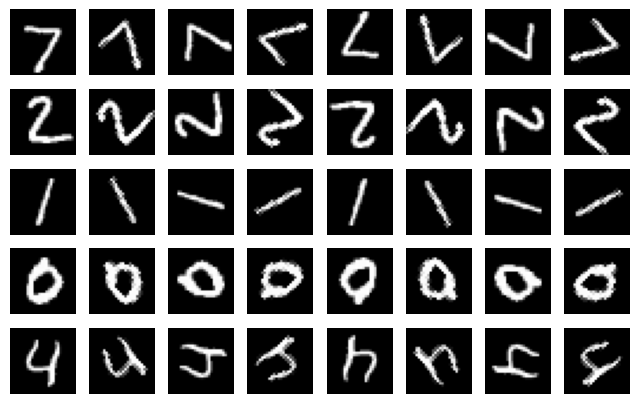

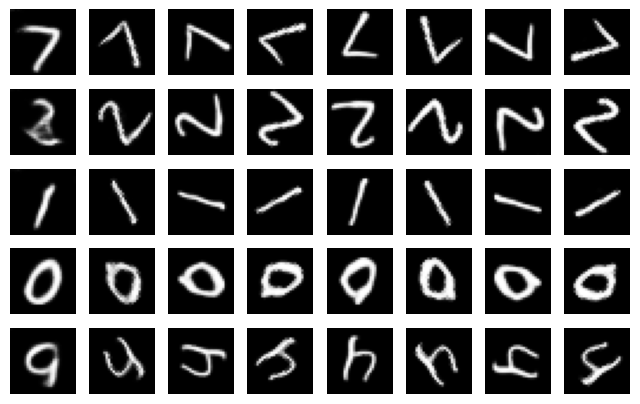

In [47]:
# Reconstructions

n_samples = 5
t = 8
recons = torch.zeros(n_samples, t, 28, 28)
model.eval()

with torch.inference_mode():
    x,_ = next(iter(test_dataloader))
    x = x.to(device)
    _,recon_x = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.unsqueeze(2).cpu().numpy()

imshow_grid(x, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid(recon_x, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [48]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.049485
t=1 MSE per pixel:0.015700
t=2 MSE per pixel:0.009272
t=3 MSE per pixel:0.007309
t=4 MSE per pixel:0.005534
t=5 MSE per pixel:0.005740
t=6 MSE per pixel:0.004937
t=7 MSE per pixel:0.005366


In [49]:
mse_T

array([0.04948511, 0.01570044, 0.00927198, 0.00730931, 0.00553378,
       0.00574019, 0.00493712, 0.00536636], dtype=float32)

Text(0, 0.5, 'MSE per Pixel')

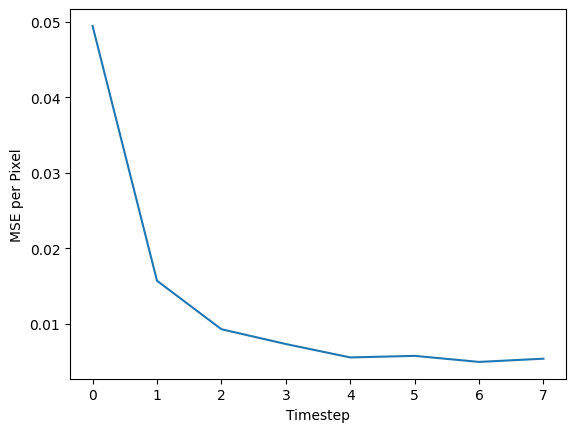

In [50]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.ylabel('MSE per Pixel')

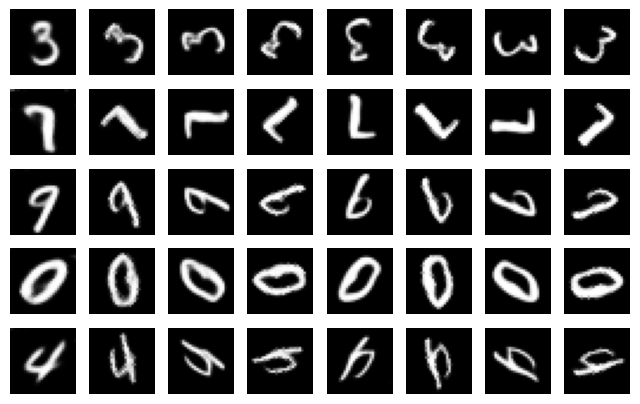

In [14]:
# Create samples

n_samples = 5
t = 8
model.eval()
with torch.inference_mode():
    s = model.sample(seq_len = t, n_samples=n_samples)
    s = s.cpu().numpy()
 
imshow_grid(s, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)      

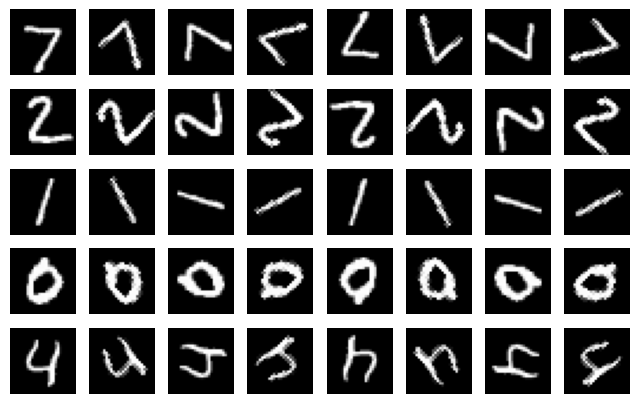

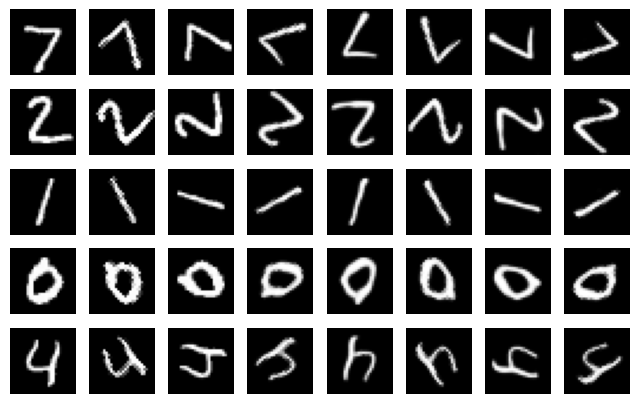

In [58]:
# Predictions

with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device))
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=5).cpu()
    x = x.cpu()
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.numpy()

imshow_grid((x[:5]), n_row=5, n_col=8, fig_size_a=8, fig_size_b=5)
imshow_grid((preds[:5]), n_row=5, n_col=8, fig_size_a=8, fig_size_b=5)


In [59]:
with torch.inference_mode():
    predict_mse = []
    for (sample,_) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        preds = model.predict_sequence(obs_var[:,:3], seq_len=5)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 5, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [60]:
predict_mse[0]

[0.0071260337717831135,
 0.007264852058142424,
 0.010240120813250542,
 0.011714108288288116,
 0.014395760372281075]

([<matplotlib.axis.XTick at 0x7b0c2f280130>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

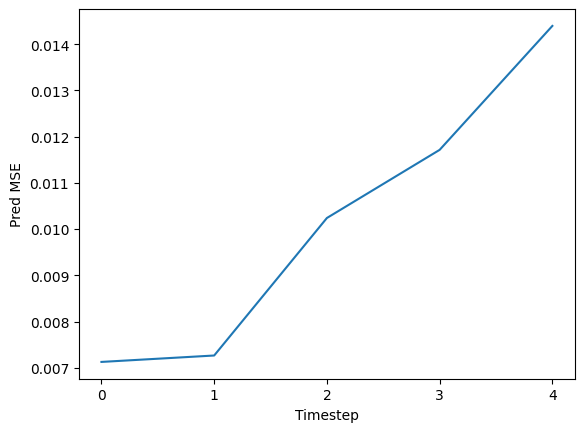

In [61]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')
plt.xticks(np.arange(0,5))

# FIVO

In [12]:
epochs = 10
particles = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  0%|          | 0/938 [00:00<?, ?batch/s]/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/vol/bitbucket/am9923/myenv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0: 100%|██████████| 938/938 [05:18<00:00,  2.94batch/s, loss=82.9231] 


Recon MSE: 0.01650
Pred MSE: 0.02116


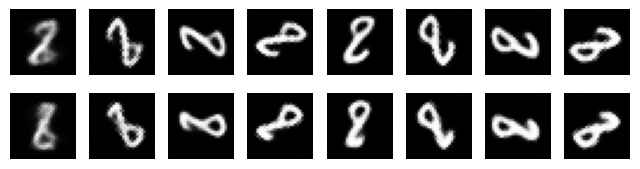

Epoch 1: 100%|██████████| 938/938 [05:21<00:00,  2.92batch/s, loss=67.7412]


Recon MSE: 0.01460
Pred MSE: 0.01669


Epoch 2: 100%|██████████| 938/938 [05:16<00:00,  2.96batch/s, loss=60.0586]


Recon MSE: 0.01375
Pred MSE: 0.01541


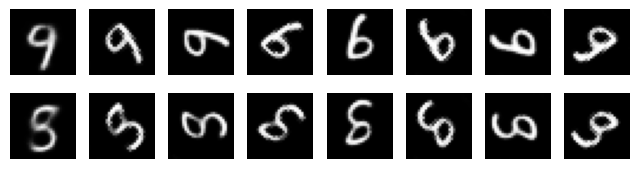

Epoch 3: 100%|██████████| 938/938 [05:13<00:00,  2.99batch/s, loss=53.6034]


Recon MSE: 0.01277
Pred MSE: 0.01309


Epoch 4: 100%|██████████| 938/938 [05:12<00:00,  3.00batch/s, loss=47.6102]


Recon MSE: 0.01224
Pred MSE: 0.01234


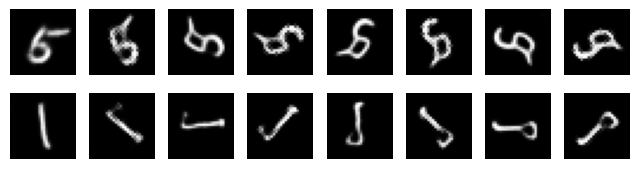

Epoch 5: 100%|██████████| 938/938 [05:13<00:00,  2.99batch/s, loss=48.5600]


Recon MSE: 0.01184
Pred MSE: 0.01110


Epoch 6: 100%|██████████| 938/938 [05:21<00:00,  2.92batch/s, loss=45.3673]


Recon MSE: 0.01155
Pred MSE: 0.01114


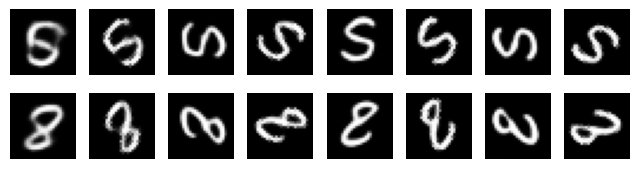

Epoch 7: 100%|██████████| 938/938 [05:23<00:00,  2.90batch/s, loss=48.5291]


Recon MSE: 0.01094
Pred MSE: 0.00961


Epoch 8: 100%|██████████| 938/938 [05:14<00:00,  2.98batch/s, loss=44.2222]


Recon MSE: 0.01104
Pred MSE: 0.00847


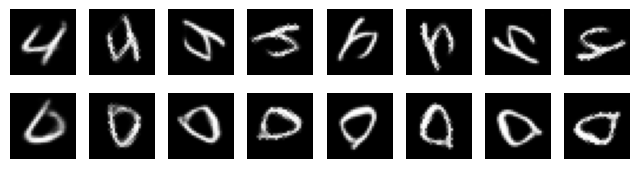

Epoch 9: 100%|██████████| 938/938 [05:29<00:00,  2.84batch/s, loss=51.6744]


Recon MSE: 0.01133
Pred MSE: 0.00942


In [13]:
total_losses_fivo = []
mse_losses_fivo = []
predict_mse_fivo = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            data = data.to(device)
            optimizer.zero_grad()
            total_loss, log_probs = model.fivo(data, particles)
            total_loss = - total_loss
        
            # Keep in memory the losses
            total_losses_fivo.append(total_loss.item())
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            total_loss.backward()
            optimizer.step()
            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.4f}")
                
    model.eval()
    with torch.inference_mode():
        mse_values = []
        predict_mse = []
        for (sample, _) in test_dataloader:
            B, T, C, H, W = sample.size()                    
            obs_var = sample.float().to(device)
            _, x_hat = model(obs_var)
            preds = model.predict_sequence(obs_var[:,:3], seq_len=(T-3))
            obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().reshape(B, T, C, H, W).numpy()
            preds = preds.cpu().reshape(B, (T-3), C, H, W).numpy()
            mse = np.mean(((x_hat - obs_var) ** 2))
            pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))  
            mse_values.append(mse)
            predict_mse.append(pred_mse)            
        mse_val = sum(mse_values) / len(mse_values)
        pred_val = sum(predict_mse) / len(predict_mse)
        mse_losses_fivo.append(mse_val.item())
        predict_mse_fivo.append(pred_val.item())   
        print(f"Recon MSE: {mse_val:.5f}")
        print(f"Pred MSE: {pred_val:.5f}")                       

    if epoch%2==0:       
        with torch.inference_mode():
            s = model.sample(seq_len = 8, n_samples=2)
            s = s.cpu().numpy()     
        imshow_grid(s, n_row=2, n_col=8, fig_size_a=8, fig_size_b=2)  

In [14]:
PATH = 'vrnn_mnist_fivo_3.pth'
torch.save(model.state_dict(), PATH)
# model.load_state_dict(torch.load(PATH))

In [15]:
mse_losses_fivo, predict_mse_fivo

([0.01649892292445219,
  0.014596781386887725,
  0.013745574870064288,
  0.01277188142124988,
  0.01224285342930993,
  0.01183811505619861,
  0.011547223888809167,
  0.010942399218867097,
  0.01103798823454712,
  0.011325048259164713],
 [0.021160906958806364,
  0.01668997897613275,
  0.015412394299254388,
  0.013087786734104156,
  0.012344420215562929,
  0.011099535382435292,
  0.011137994100587278,
  0.009605412654390064,
  0.008474147023892478,
  0.009418809910222321])

Text(0, 0.5, 'Training Loss')

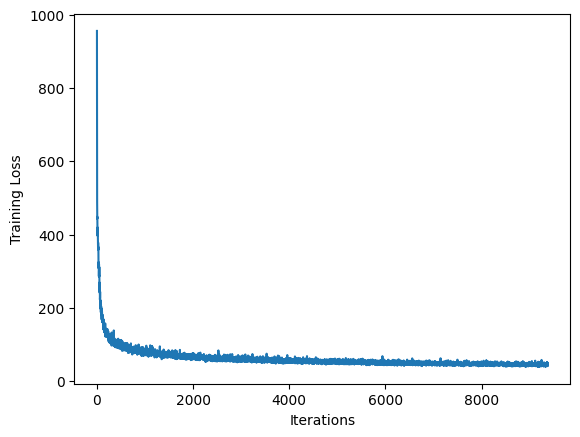

In [16]:
plt.plot(total_losses_fivo)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

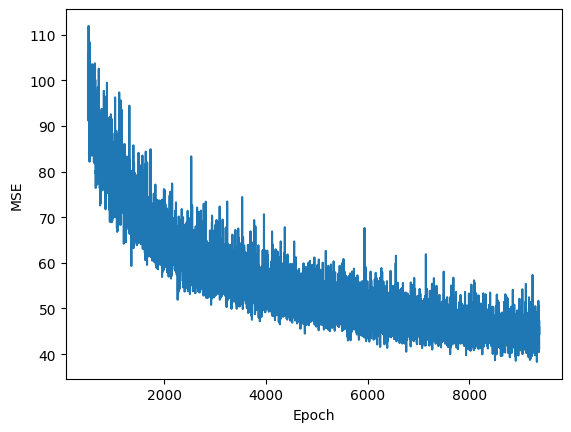

In [17]:
plt.plot(np.arange(500,len(total_losses_fivo)),total_losses_fivo[500:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

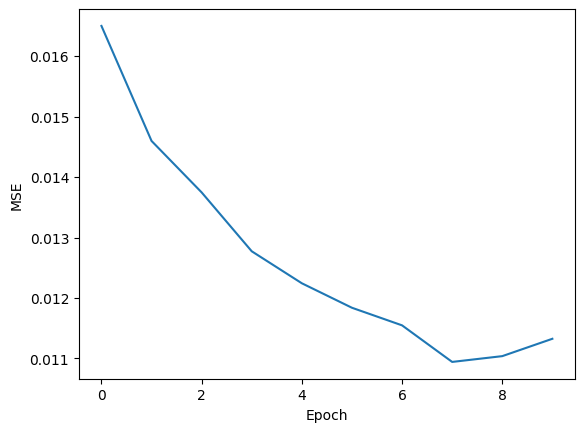

In [18]:
plt.plot(mse_losses_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

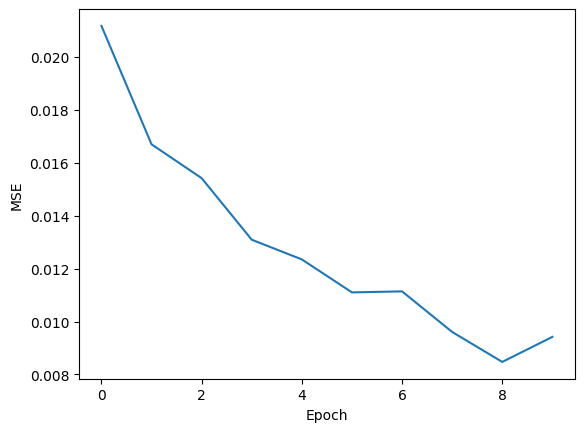

In [19]:
plt.plot(predict_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [20]:
# Training time: 56min
print(f"Last FIVO Loss: {total_losses_fivo[-1]:.1f}")
print(f"Last Test MSE: {mse_losses_fivo[-1]:.6f}")
print(f"Last Pred MSE: {predict_mse_fivo[-1]:.6f}")

Last FIVO Loss: 45.9
Last Test MSE: 0.011325
Last Pred MSE: 0.009419


In [21]:
print(f"Best FIVO Loss: {min(total_losses_fivo):.1f}")
print(f"Best Test MSE: {min(mse_losses_fivo):.6f}")
print(f"Best Pred MSE: {min(predict_mse_fivo):.6f}")

Best FIVO Loss: 38.3
Best Test MSE: 0.010942
Best Pred MSE: 0.008474


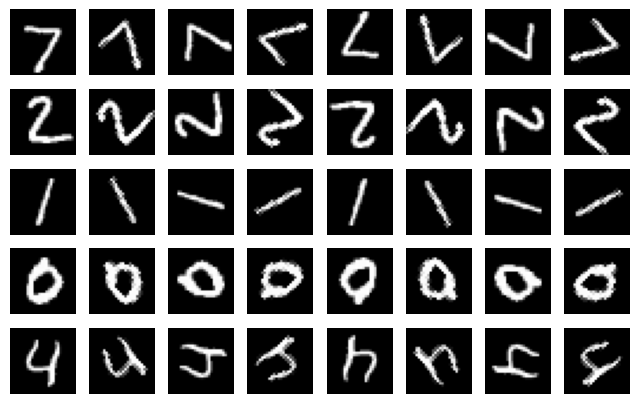

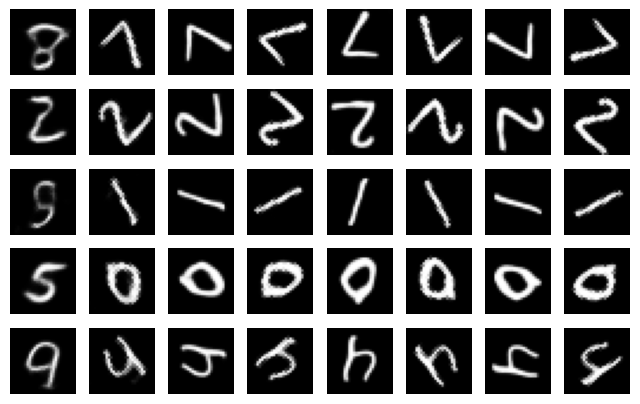

In [22]:
# Reconstructions

n_samples = 5
t = 8
recons = torch.zeros(n_samples, t, 28, 28)
model.eval()

with torch.inference_mode():
    x,_ = next(iter(test_dataloader))
    x = x.to(device)
    _,recon_x = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.unsqueeze(2).cpu().numpy()

imshow_grid(x, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)
imshow_grid(recon_x, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)

In [23]:
# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2,3,4))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.049953
t=1 MSE per pixel:0.010820
t=2 MSE per pixel:0.006582
t=3 MSE per pixel:0.005201
t=4 MSE per pixel:0.004855
t=5 MSE per pixel:0.004566
t=6 MSE per pixel:0.004360
t=7 MSE per pixel:0.004363


In [24]:
mse_T

array([0.04995269, 0.01082006, 0.00658184, 0.00520093, 0.00485477,
       0.00456602, 0.00436025, 0.00436294], dtype=float32)

Text(0, 0.5, 'MSE per Pixel')

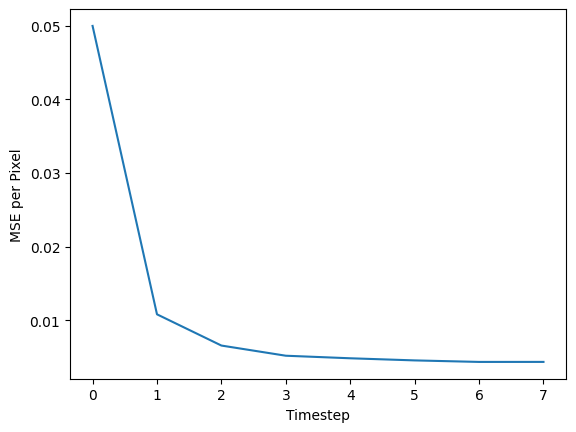

In [25]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.ylabel('MSE per Pixel')

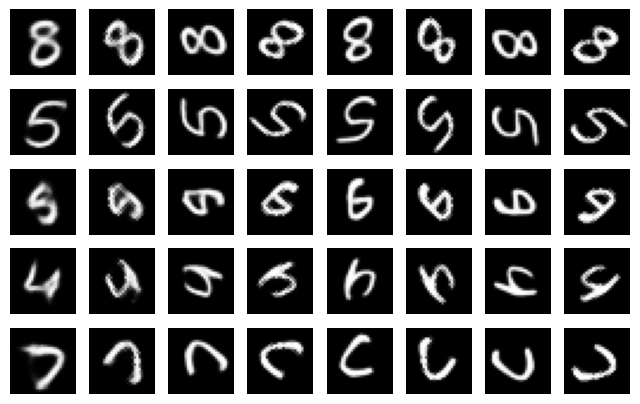

In [28]:
# Create samples

n_samples = 5
t = 8
model.eval()
with torch.inference_mode():
    s = model.sample(seq_len = t, n_samples=n_samples)
    s = s.cpu().numpy()
 
imshow_grid(s, n_row=n_samples, n_col=t, fig_size_a=t, fig_size_b=n_samples)      

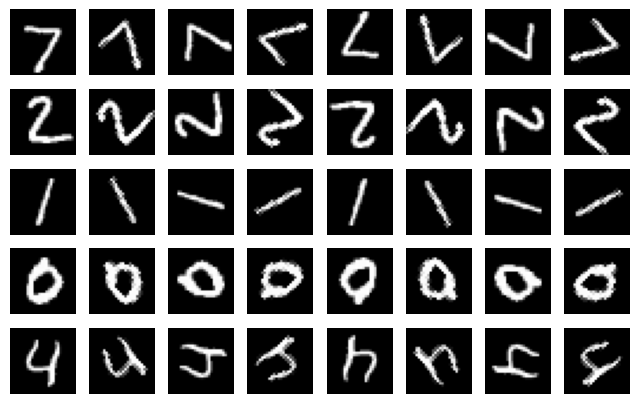

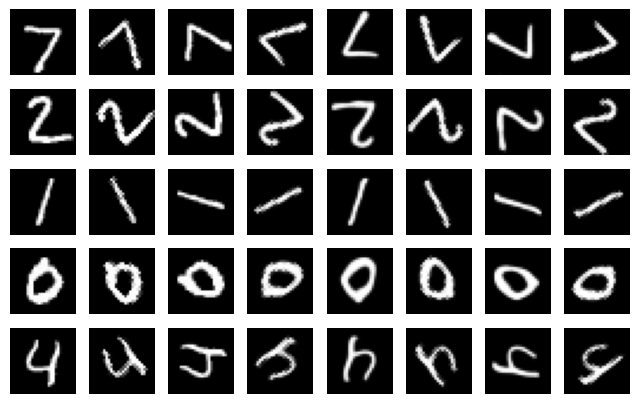

In [29]:
# Predictions

with torch.inference_mode():
    x = next(iter(test_dataloader))[0]
    x = (x.float().to(device))
    B = x.shape[0]
    preds = model.predict_sequence(x[:,:3], seq_len=5).cpu()
    x = x.cpu()
    preds = torch.cat((x[:,:3],preds),dim=1).cpu().numpy()
    x = x.numpy()

imshow_grid((x[:5]), n_row=5, n_col=8, fig_size_a=8, fig_size_b=5)
imshow_grid((preds[:5]), n_row=5, n_col=8, fig_size_a=8, fig_size_b=5)

In [30]:
with torch.inference_mode():
    predict_mse = []
    for (sample,_) in test_dataloader:
        mse_values = []
        B, T, C, H, W = sample.size()
        obs_var = sample.float().to(device)
        preds = model.predict_sequence(obs_var[:,:3], seq_len=5)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().reshape(B, 5, C, H, W).numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2,3,4))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

In [31]:
predict_mse[0]

[0.005425445269793272,
 0.00696664210408926,
 0.009112292900681496,
 0.010860105976462364,
 0.012507248669862747]

([<matplotlib.axis.XTick at 0x7d7f1bff3c70>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4')])

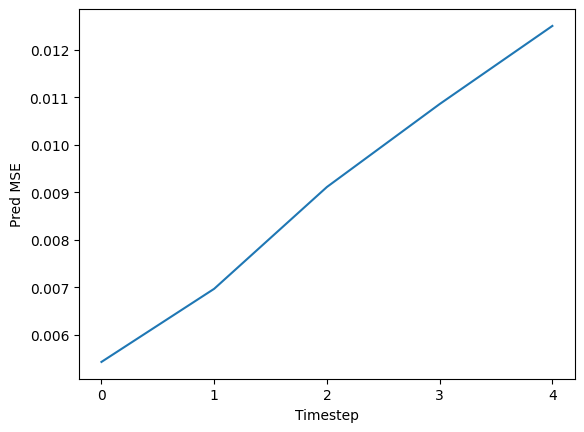

In [32]:
plt.plot(predict_mse[0])
plt.xlabel('Timestep')
plt.ylabel('Pred MSE')
plt.xticks(np.arange(0,5))

# Lower Bound Analysis

In [40]:
epochs = 10
particles = 10
learning_rate = 1e-3
model = VRNN(h_dim=64,z_dim=128)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
total_losses = []

elbo_list = []
iwae_list = []
fivo_list = []

for epoch in range(epochs):
    model.train()
    with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            data = data.to(device)
            optimizer.zero_grad()
            total_loss, _ = model.fivo(obs_var, particles)
            total_loss = -total_loss

            # Keep in memory the losses
            total_losses.append(total_loss.item())

            total_loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(loss=f"{total_loss.item():.3f}")
    model.eval()
    with torch.inference_mode():
        for (sample, _) in test_dataloader:
            B, T, C, H, W = sample.size()                    
            obs_var = sample.float().to(device)
            elbo_loss, _ = model(obs_var)
            iwae_loss, _ = model.iwae(obs_var, particles)
            fivo_loss, _ = model.fivo(obs_var, particles)

            elbo_list.append((-elbo_loss).cpu().numpy())
            iwae_list.append((iwae_loss).cpu().numpy())
            fivo_list.append((fivo_loss).cpu().numpy())
                                    

  0%|          | 0/938 [00:00<?, ?batch/s]

Epoch 9: 100%|██████████| 938/938 [04:27<00:00,  3.50batch/s, loss=4.562]


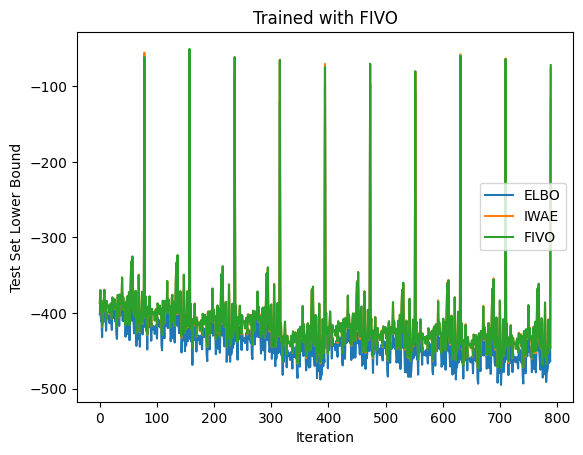

In [44]:
x_values = range(len(elbo_list))

# Plot the arrays
plt.plot(x_values, elbo_list, alpha=1.0, label='ELBO')
plt.plot(x_values, iwae_list, alpha=1.0, label='IWAE')
plt.plot(x_values, fivo_list, alpha=1.0, label='FIVO')

plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Test Set Lower Bound')
plt.title('Trained with IWAE')

# Show the plot
plt.show()

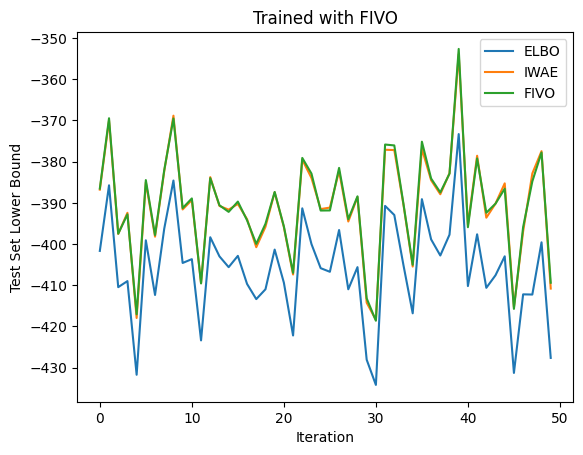

In [45]:
x_values = range(len(elbo_list))

# Plot the arrays
plt.plot(x_values[0:50], elbo_list[0:50], alpha=1.0, label='ELBO')
plt.plot(x_values[0:50], iwae_list[0:50], alpha=1.0, label='IWAE')
plt.plot(x_values[0:50], fivo_list[0:50], alpha=1.0, label='FIVO')

plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Test Set Lower Bound')
plt.title('Trained with IWAE')

# Show the plot
plt.show()

In [34]:
# Trained with ELBO
print(np.array(elbo_list))
print(np.array(iwae_list))
print(np.array(fivo_list))

[-128.201    -127.96312  -129.01183  -133.78734  -135.58105  -130.76515
 -132.87572  -128.9482   -133.02914  -131.95303  -129.95026  -135.60608
 -131.41135  -126.76732  -127.19345  -129.3845   -136.12018  -131.5158
 -130.91937  -132.71924  -130.13882  -130.56938  -134.02684  -130.87007
 -128.55867  -131.05728  -131.07599  -135.55159  -130.39053  -138.41107
 -135.95284  -131.6719   -134.13396  -128.00209  -133.95245  -134.094
 -131.27893  -134.85246  -127.64825  -143.60312  -131.33575  -135.56694
 -142.76558  -140.0934   -139.12166  -141.42989  -148.12714  -166.3258
 -149.44536  -143.3943   -146.0549   -122.58817  -155.00377  -133.65541
 -137.92603  -139.50194  -135.02045  -139.88187  -135.5992   -133.33032
 -155.6098   -181.3949   -162.49103  -152.45837  -151.09482  -152.54564
 -159.2731   -133.29295  -139.19397  -142.6471   -156.79987  -159.62767
 -133.45473  -133.47824  -147.87161  -142.57089  -136.52815  -132.55658
 -155.03674   -93.02216   -91.27653   -93.04512   -97.21641   -99.27

In [39]:
# Trained with IWAE
print(np.array(elbo_list))
print(np.array(iwae_list))
print(np.array(fivo_list))

[-412.59604  -395.72412  -426.55502  -417.22183  -441.56622  -415.2013
 -425.2921   -410.80685  -398.64044  -411.82706  -414.57346  -435.31885
 -414.32574  -416.00864  -416.2862   -413.9615   -423.13977  -425.38736
 -420.5278   -414.27533  -423.40402  -428.49243  -406.11432  -404.25937
 -413.0518   -415.80878  -411.50073  -419.22827  -415.88736  -438.60626
 -442.9569   -406.97522  -414.30066  -414.11893  -423.5426   -403.3871
 -415.2099   -415.24316  -414.87433  -392.96246  -423.3038   -408.88773
 -429.33075  -422.75995  -423.94522  -444.2579   -419.54376  -431.65552
 -420.66083  -440.87015  -439.52356  -390.3247   -439.40805  -422.2795
 -383.752    -366.5686   -423.86575  -370.36636  -409.1792   -422.4599
 -441.91443  -434.51254  -420.3609   -413.2107   -453.04288  -437.53345
 -460.57986  -443.43915  -392.54092  -419.107    -460.5429   -443.33694
 -436.36136  -429.9462   -405.90863  -427.05444  -414.97986  -418.66016
 -143.57986  -417.48267  -399.1182   -428.24548  -420.049    -445.51

In [46]:
# Trained with FIVO
print(np.array(elbo_list))
print(np.array(iwae_list))
print(np.array(fivo_list))

[-401.67972  -385.74857  -410.4826   -409.01035  -431.7555   -399.10663
 -412.37674  -396.27905  -384.59454  -404.61035  -403.6808   -423.4104
 -398.36325  -403.00516  -405.62643  -402.88318  -409.70193  -413.38754
 -410.99994  -401.36053  -409.39362  -422.21564  -391.3468   -400.02277
 -405.8733   -406.75128  -396.6059   -410.99844  -405.6222   -428.10474
 -434.22086  -390.75275  -392.96255  -405.19156  -416.8307   -389.12155
 -398.87503  -402.79776  -397.73746  -373.31134  -410.21436  -397.64365
 -410.6458   -407.5918   -402.9923   -431.3103   -412.2288   -412.2747
 -399.59747  -427.6604   -425.30417  -386.6144   -435.80072  -402.21545
 -371.17798  -347.6278   -410.0178   -346.95355  -408.2728   -410.7058
 -426.8353   -416.72537  -396.8978   -392.5408   -443.39636  -420.30618
 -434.93817  -425.11716  -372.05737  -404.2736   -444.49695  -420.686
 -425.77853  -421.9202   -390.4346   -428.07355  -414.03806  -418.60287
  -79.18341  -415.1139   -398.55444  -423.11     -416.2345   -448.177